# TM10007 Assignment template

In [32]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [33]:
# Imports

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn utilities
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_predict,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
    learning_curve
)

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler

# Feature selection
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    mutual_info_classif,
    VarianceThreshold,
    RFECV,
    SelectFromModel
)
from sklearn.feature_selection import SequentialFeatureSelector

# Dimensionality reduction
from sklearn.decomposition import PCA

# Statistical testing
from scipy.stats import shapiro, randint
import scipy.stats as stats

# Classifiers
from sklearn.linear_model import (
    LogisticRegression,
    SGDClassifier,
    Lasso,
    LassoCV
)
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)
from sklearn.svm import SVC

# Evaluation metrics
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    accuracy_score,
    f1_score
)

# Other utilities
import copy
from sklearn.base import clone
from typing import List, Tuple, Union

# Custom module
from worclipo.load_data import load_data


In [34]:
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

X = data.drop("label",axis=1)
y = data["label"]

#X_train, X_test, y_train, y_test = train_test_split(
    #X, y, test_size=0.2, random_state=42, stratify=y
#)

The number of samples: 115
The number of columns: 494


Figure data distribution

In [ ]:
import matplotlib.pyplot as plt

# Selecteer de eerste 25 features
features = X.columns[:25]

# Plot de histogrammen
plt.figure(figsize=(20, 15))
for i, feature in enumerate(features):
    plt.subplot(5, 5, i + 1)
    plt.hist(X[feature].dropna(), bins=30, edgecolor='black')
    plt.title(feature, fontsize=8)
    plt.xlabel("Waarde", fontsize=6)
    plt.ylabel("Frequentie", fontsize=6)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.grid(True)

plt.suptitle("Features 1 t/m 25", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

General functions to be used

In [35]:
# Some functions we will use

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_roc_curve(y_score, y_truth):
    '''
    Plot an ROC curve.
    '''
    # Only take scores for class = 1
    y_score = y_score[:, 1]

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_truth, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

### Preprocessing

Missing data
* Part 1: Finding missing data

In [36]:
def find_missing_data(X_train):

    # Define missing value indicators
    custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-']

    # Count NaNs
    nan_counts = X_train.isna().sum()

    # Count empty strings
    empty_string_counts = (X_train == '').sum()

    # Count custom missing indicators (case-insensitive match)
    custom_missing_counts = X_train.apply(lambda col: col.astype(str).str.lower().isin([val.lower() for val in custom_missing]).sum())

    # Compute total missing count per column
    total_missing = nan_counts + empty_string_counts + custom_missing_counts

    # Filter out columns where total missing is zero
    total_missing_selected = total_missing[total_missing != 0]

    # Print total missing counts
    print(total_missing_selected)

    return total_missing

#total_missing = find_missing_data(X_train)

* Part 2: Processing missing data

In [37]:
def process_missing_data(X_train, X_test, total_missing):

    # Replacing missing values with NaN
    custom_missing = ['NA', 'N/A', '?', 'None', 'none', '-', '']
    X_train.replace(custom_missing, np.nan, inplace=True)
    X_test.replace(custom_missing, np.nan, inplace=True)

    # If 50% or more of the data within one feature is missing the feature is deleted
    limit = len(X_train.index)*50/100
    valid_columns = [col for col, count in total_missing.items() if count < limit]

    # Keep only the valid columns in both X_train and X_test
    X_train = X_train[valid_columns]
    X_test = X_test[valid_columns]

    # Imputate

    # Check if imputation is needed
    if X_train.isna().sum().sum() == 0:
        pass
    else:
        # Dictionary to store mean/median decision per column
        imputation_strategies = {}

        for col in X_train.select_dtypes(include=['number']).columns:  # Only numeric columns
            col_data = X_train[col].dropna()  # Remove NaN values for testing

            if len(col_data) > 3:  # Shapiro requires at least 3 non-null values
                if col_data.nunique() == 1:  # Check if all values are the same
                    strategy = 'median'  # Default to median if no variability
                else:
                    _, p = shapiro(col_data)
                    strategy = 'mean' if p > 0.05 else 'median'
            else:
                strategy = 'median'  # Default to median if too few values

            imputation_strategies[col] = strategy

        # Create imputers for mean and median
        mean_imputer = SimpleImputer(strategy='mean')
        median_imputer = SimpleImputer(strategy='median')

        # Apply imputers for each feature
        for col, strategy in imputation_strategies.items():
            imputer = mean_imputer if strategy == 'mean' else median_imputer
            X_train[col] = imputer.fit_transform(X_train[[col]])
            X_test[col] = imputer.transform(X_test[[col]])  # Use the same imputer
    
    return X_train, X_test

#X_train, X_test = process_missing_data(X_train, X_test, total_missing)

Scaling data

In [38]:
def scaling(X_train, X_test):
    """
    Scales training and testing feature datasets using RobustScaler.

    This function applies robust scaling to the input training and testing datasets.
    RobustScaler removes the median and scales the data according to the interquartile range (IQR),
    making it more robust to outliers compared to standard scaling techniques.

    Parameters:
    ----------
    X_train : pandas.DataFrame
        The training data to be scaled.
    X_test : pandas.DataFrame
        The testing data to be scaled.

    Returns:
    -------
    X_scaled_robust_train : pandas.DataFrame
        The scaled version of the training dataset.
    X_scaled_robust_test : pandas.DataFrame
        The scaled version of the testing dataset.
    """

    scaler_robust = preprocessing.RobustScaler()

    scaled_robust_array_train = scaler_robust.fit_transform(X_train)
    scaled_robust_array_test = scaler_robust.transform(X_test)

    X_scaled_robust_train = pd.DataFrame(scaled_robust_array_train, columns=X_train.columns)
    X_scaled_robust_test = pd.DataFrame(scaled_robust_array_test, columns=X_test.columns)

    return X_scaled_robust_train, X_scaled_robust_test

#X_scaled_robust_train, X_scaled_robust_test = scaling(X_train, X_test)

### Feature extraction

First step: variance based thresholding

In [39]:
def apply_variance_threshold(X_train, X_test, threshold=0.95):
    """
    Applies variance thresholding to remove low-variance features.

    Args:
        X_train (pd.DataFrame): Scaled training feature set.
        X_test (pd.DataFrame): Scaled test feature set.
        threshold (float): Threshold for variance. Features with variance below this will be removed.

    Returns:
        X_train_filtered (pd.DataFrame): Filtered training set.
        X_test_filtered (pd.DataFrame): Filtered test set.
        selected_features (List[str]): Names of the retained features.
    """
    selector_variance_threshold = VarianceThreshold(threshold=threshold)
    X_train_filtered_variance_np = selector_variance_threshold.fit_transform(X_train)
    selected_features = X_train.columns[selector_variance_threshold.get_support()]
    
    X_train_filtered = pd.DataFrame(X_train_filtered_variance_np, columns=selected_features, index=X_train.index)
    X_test_filtered = pd.DataFrame(selector_variance_threshold.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[VarianceThreshold] Remaining features: {len(selected_features)}")
    return X_train_filtered, X_test_filtered, selected_features

#X_filtered_train_variance_new, X_filtered_test_variance_new, variance_filtered_features_new = apply_variance_threshold(X_scaled_robust_train, X_scaled_robust_test)
#print(X_filtered_train_variance_new.shape)
#print(X_filtered_test_variance_new.shape)

Filtering with ANOVA: linear relations

In [40]:
def select_features_anova(X_train, y_train, X_test, k=75, plot=True):
    """
    Selects the top-k features using ANOVA F-test (for linear dependencies).

    Args:
        X_train (pd.DataFrame): Training features. 
        y_train (pd.Series or np.array): Training labels, numerically encoded
        X_test (pd.DataFrame): Test features.
        k (int): Number of top features to select.
        plot (bool): If True, visualizes F-statistics and top 2 feature scatter plot.

    Returns:
        X_train_anova (pd.DataFrame): Training set with selected features.
        X_test_anova (pd.DataFrame): Test set with selected features.
        selected_features (List[str]): Names of the selected features.
    """
    selector_anova = SelectKBest(f_classif, k=k)
    X_train_filtered_anova_np = selector_anova.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector_anova.get_support()]
    
    X_train_anova = pd.DataFrame(X_train_filtered_anova_np, columns=selected_features, index=X_train.index)
    X_test_anova = pd.DataFrame(selector_anova.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[ANOVA] Selected top-{k} features.")
    return X_train_anova, X_test_anova, selected_features

# Transform labels to numeric values, i.e. 0 or 1 
#le = LabelEncoder()
#y_train_numeric = le.fit_transform(y_train)
#legend_labels = le.classes_  # shows mapping from labels to numbers (for plotting/checking)

#X_filtered_train_anova_new, X_filtered_test_anova_new, anova_selected_features_new = select_features_anova(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
# print(anova_selected_features_new)
# print(X_filtered_test_anova_new)

Filtering with mutual information: non-linear relationships

In [41]:
def select_features_mi(X_train, y_train, X_test, k=75, plot=True, random_state=42):
    """
    Selects the top-k features using mutual information (for non-linear dependencies).

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series or np.array): Training labels, numerically encoded
        X_test (pd.DataFrame): Test features.
        k (int): Number of top features to select.
        plot (bool): If True, plots MI scores and a 2D scatterplot of top 2 features.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train_mi (pd.DataFrame): Training set with selected features.
        X_test_mi (pd.DataFrame): Test set with selected features.
        selected_features (List[str]): Names of the selected features.
    """
    selector_mi = SelectKBest(lambda X, y: mutual_info_classif(X, y, random_state=random_state), k=k)
    X_train_filtered_mi_np = selector_mi.fit_transform(X_train, y_train)
    selected_features = X_train.columns[selector_mi.get_support()]

    X_train_mi = pd.DataFrame(X_train_filtered_mi_np, columns=selected_features, index=X_train.index)
    X_test_mi = pd.DataFrame(selector_mi.transform(X_test), columns=selected_features, index=X_test.index)

    print(f"[Mutual Information] Selected top-{k} features.")
    return X_train_mi, X_test_mi, selected_features

#X_filtered_train_mi_new, X_filtered_test_mi_new, mi_selected_features_new = select_features_mi(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)

Take union of ANOVA & MI selected sets: in this way we take linear and non-linear relations in the data

In [42]:
def combine_feature_sets_union(X_full_train, X_full_test, features1, features2):
    """
    Creates a feature subset based on the union of two feature lists.

    Args:
        X_full_train (pd.DataFrame): Original training DataFrame (after variance filtering).
        X_full_test (pd.DataFrame): Original test DataFrame (after variance filtering).
        features1 (List[str]): List of selected features (e.g., from ANOVA).
        features2 (List[str]): List of selected features (e.g., from MI).

    Returns:
        X_union_train (pd.DataFrame): Training set with union of features.
        X_union_test (pd.DataFrame): Test set with union of features.
        union_features (List[str]): Combined list of feature names.
    """
    union_features = list(set(features1).union(set(features2)))
    X_union_train = X_full_train[union_features]
    X_union_test = X_full_test[union_features]

    print(f"[Feature Union] Combined feature set size: {len(union_features)}")
    return X_union_train, X_union_test, union_features

#X_filtered_train_union_new, X_filtered_test_union_new, union_features_new = combine_feature_sets_union(X_filtered_train_variance_new, X_filtered_test_variance_new, anova_selected_features_new, mi_selected_features_new)
#print(len(union_features_new))
#print(union_features_new)

In [43]:
# Bijvoorbeeld op een paar features uit union:
#for feature in union_features_new[:70]:  # check bijv. eerste 5 features
    # sns.histplot(X_filtered_train_union_new[feature], kde=True)
    # plt.title(f'Distribution of {feature}')
    # plt.show()

    #stat, p = stats.shapiro(X_filtered_train_union_new[feature])
    #print(f"{feature}: p={p} (Shapiro-Wilk Test)")
    #if p > 0.05:
        #print(f"Feature {feature} follows a normal distribution")


In [ ]:
def greedy_forward_selection(
    X_train: pd.DataFrame,
    y_train: Union[pd.Series, list, np.ndarray],
    X_test: pd.DataFrame,
    model=None,
    feature_range: List[int] = None,
    scoring: str = 'accuracy',
    cv_splits: int = 5,
    plot: bool = True
) -> Tuple[pd.DataFrame, pd.DataFrame, List[str], int, float]:
    """
    Applies greedy forward feature selection with a given model.

    Args:
        X_train (pd.DataFrame): Training features.
        y_train (array-like): Training labels.
        X_test (pd.DataFrame): Test features.
        model: Scikit-learn classifier (default: LogisticRegression).
        feature_range (list): List of n_features_to_select to evaluate.
        scoring (str): Scoring metric (e.g. 'accuracy', 'roc_auc').
        cv_splits (int): Number of folds for cross-validation.
        plot (bool): Whether to plot accuracy vs. feature count.

    Returns:
        X_train_selected (pd.DataFrame): Selected training features.
        X_test_selected (pd.DataFrame): Selected test features.
        best_features (List[str]): Names of selected features.
        best_n_features (int): Number of selected features.
        best_accuracy (float): Training accuracy using selected features.
    """
    if model is None:
        from sklearn.linear_model import LogisticRegression
        model = LogisticRegression(max_iter=1000, random_state=42)

    if feature_range is None:
        total_features = X_train.shape[1]
        minimum_number_to_select = 1
        maximum_number_to_select = len(total_features)
        stepsize = 1
        feature_range = list(range(minimum_number_to_select, maximum_number_to_select+1, stepsize))

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    best_accuracy = 0
    best_n_features = None
    best_features = []
    accuracy_list = []

    for n_features in feature_range:
        print(f"Testing n_features_to_select = {n_features}")

        sfs = SequentialFeatureSelector(
            model,
            n_features_to_select=n_features,
            direction='forward',
            scoring=scoring,
            cv=cv,
            n_jobs=-1
        )
        sfs.fit(X_train, y_train)
        selected = list(X_train.columns[sfs.get_support()])

        X_train_sel = X_train[selected]
        X_test_sel = X_test[selected]

        # new model per run
        current_model = clone(model)
        current_model.fit(X_train_sel, y_train)
        acc = current_model.score(X_train_sel, y_train)
        accuracy_list.append(acc)

        print(f"Accuracy for {n_features} features: {acc:.4f}")

        if acc > best_accuracy:
            best_accuracy = acc
            best_n_features = n_features
            best_features = selected

    #if plot:
        #plt.figure(figsize=(8, 5))
        #plt.plot(feature_range, accuracy_list, marker='o')
        #plt.xlabel("Number of Features")
        #plt.ylabel(f"Training {scoring.capitalize()}")
        #plt.title("Greedy Forward Selection Performance")
        #plt.grid(True)
        #plt.show()

    print("\n Greedy Forward Selection complete.")
    print(f"Optimal number of features: {best_n_features}")
    print(f"Best training {scoring}: {best_accuracy:.4f}")

    X_train_best = X_train[best_features]
    X_test_best = X_test[best_features]

    return X_train_best, X_test_best, best_features, best_n_features, best_accuracy

# Feature selection for the Logistic Regression Classifier
# Base estimator = Linear Regression
# Optimize number of features between 10 and the number of features in the union
#X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, sfs_selected_features_logistic, number_of_sfs_selected_features_logistic, train_acc_logistic = greedy_forward_selection(
    #X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    #model=LogisticRegression(max_iter=1000, random_state=42),
    #feature_range=list(range(80, 100, 5)),
    #scoring='accuracy'
#)

In [45]:
# Feature selection for the SVM classifier
# Base estimator = Linear Regression
# Optimize number of features with a max of 10
#X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, sfs_selected_features_logistic_max10, number_of_sfs_selected_features_logistic_max10, train_acc_logistic_max10 = greedy_forward_selection(
    #X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    #model=LogisticRegression(max_iter=1000, random_state=42),
    #feature_range=list(range(1, 20, 1)),
    #scoring='accuracy'
#)

In [46]:
# First optimize k with grid search before using kNN as base esimator 

def optimal_k(X_filtered_train_union_new, y_train_numeric):

# Train tijdelijk op alle union features
    X_temp = X_filtered_train_union_new

    # parameter grid
    param_grid = {'n_neighbors': list(range(1, 21))}

    # Grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        KNeighborsClassifier(),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    # Fit grid search
    grid_search.fit(X_temp, y_train_numeric)

    # Get best k 
    best_k = grid_search.best_params_['n_neighbors']
    print(f"Best k found by grid search: {best_k}")
    print(f"Cross-validated accuracy: {grid_search.best_score_:.4f}")

    # Gebruik best_k als base estimator
    knn_best = KNeighborsClassifier(n_neighbors=best_k)

    return knn_best

#knn_best = optimal_k(X_filtered_train_union_new, y_train_numeric)

In [47]:
# Feature selection for the kNN classifier
# Base estimator = kNN classifier
# Optimize number of features between 1 and the number of features in the union
#X_train_selected_sfs_knn, X_test_selected_sfs_knn, sfs_selected_features_knn, number_of_sfs_selected_features_knn, train_acc_knn = greedy_forward_selection(
    #X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    #model=knn_best,
    #feature_range=list(range(1, 21, 1)),
    #scoring='accuracy'
#)

In [48]:
#print(sfs_selected_features_knn)

Datasets after feature extraction

In [49]:
#X_train_selected_final = X_train_selected_sfs
#print(X_train_selected_final.shape)
#X_test_selected_final = X_test_selected_sfs
#print(X_test_selected_final.shape)
#selected_features_final = sfs_selected_features
#print(len(selected_features_final))

Encode the categorical y-labels to numerical values

In [50]:
def y_numeric(y_train, y_test):
    """
    Encodes categorical labels from `y_train` and `y_test` into numeric values using `LabelEncoder`.

    This function applies `LabelEncoder` from `sklearn.preprocessing` to transform categorical target 
    labels into numerical format, which is essential for machine learning models that require numeric inputs.

    Args:
        y_train (pd.Series): The training labels.
        y_test (pd.Series): The test labels.

    Returns:
        tuple: A tuple containing:
            - `y_train_numeric` (numpy.ndarray): The transformed numeric labels for the training set.
            - `y_test_numeric` (numpy.ndarray): The transformed numeric labels for the test set.

    Prints:
        - A dictionary mapping numeric labels to their corresponding original class names.

    Note:
        The function assumes `y_train` and `y_test` contain categorical labels.
    """
    le = LabelEncoder()
    y_train_numeric = le.fit_transform(y_train)
    y_test_numeric = le.transform(y_test)

    # Store the mapping of labels
    legend_labels = le.classes_  # This saves the original class names
    print("Label Mapping:", {i: label for i, label in enumerate(legend_labels)})

    return y_train_numeric, y_test_numeric


Optimization based feature selection: LASSO

In [ ]:
def lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric):
    """
    Performs optimization based feature selection using Lasso regression.

    This function applies Lasso regression with automatic hyperparameter tuning 
    (via `LassoCV`) to identify the most important features from the robust training data.
    It selects features by penalizing less important coefficients, setting some to zero.
    
    Args:
        X_scaled_robust_train (pd.DataFrame): 
            The robust training dataset with numerical features.

    Returns:
        tuple: A tuple containing:
            - `X_train_selected` (np.ndarray): The reduced training dataset containing only selected features.
            - `X_test_selected` (np.ndarray): The reduced test dataset containing only selected features.
    
    Prints:
        - The best `alpha` value found through cross-validation.
        - The names of the selected features.

    Note:
        - This function assumes `y_train_numeric` is globally defined.
        - `SelectFromModel` is used to remove unimportant features based on the Lasso model.
    """

    # Ensure we're working with NumPy arrays for dot product
    X_np = X_scaled_robust_train.values if hasattr(X_scaled_robust_train, "values") else X_scaled_robust_train
    y_np = y_train_numeric.values if hasattr(y_train_numeric, "values") else y_train_numeric
    
    # Calculate the maximum useful alpha
    alpha_max = np.max(np.abs(X_np.T @ y_np)) / len(y_np)

    # Define LassoCV with cross-validation
    n_alphas = 200
    alphas = np.logspace(np.log10(alpha_max) - 4, np.log10(alpha_max), n_alphas)
    
    # Cross-validated Lasso
    random_state = 42 #  Using this will produce the same results everytime, 42 is along 0 the most popular choice
    lasso_cv = LassoCV(cv=5, alphas=alphas, random_state=random_state, max_iter=10000) 
    lasso_cv.fit(X_scaled_robust_train, y_train_numeric)

    # Get the best alpha value
    best_alpha = lasso_cv.alpha_
    alpha_info = [best_alpha, alpha_max]

    # Train final Lasso model with optimal alpha
    lasso = Lasso(alpha=best_alpha, fit_intercept=False) #Exclude the intercept term since the data is already centered
    lasso.fit(X_scaled_robust_train, y_train_numeric)

    # Select features
    selector = SelectFromModel(lasso, prefit=True) #Use prefit=True since the model has already been trained and fitted earlier
    X_train_selected = selector.transform(X_scaled_robust_train)
    X_test_selected = selector.transform(X_scaled_robust_test)

    # Get selected feature indices and names
    selected_features = np.where(selector.get_support())[0]
    selected_feature_names = X_scaled_robust_train.columns[selected_features]
    n_features = len(selected_features)
    
    return alpha_info, X_train_selected, X_test_selected, selected_feature_names, n_features

# Capture the return values when calling the function
#alpha_info, X_train_sel_lasso, X_test_sel_lasso, selected_feature_names, n_features = lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric)
#y_train_numeric, y_test_numeric = y_numeric(y_train, y_test)
# Print the captured values in the global scope
#print(f"Best alpha found: {best_alpha}")
#print("Selected Features:", selected_feature_names)
#print(f"N features found: {n_features}")



PCA feature extraction

In [52]:
#alpha_info, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric)

def PCA_fs(X_scaled_robust_train, X_scaled_robust_test, target_variance=0.95):
    """
    Performs Principal Component Analysis (PCA) for feature reduction.

    This function applies PCA to reduce the dimensionality of the input data, 
    transforming the training and test datasets to a lower number of features 
    (specified by `n_features`), while retaining as much variance as possible.

    Args:
        n_features (int): 
            The number of principal components to retain after performing PCA.
            Based on the number of features of Lasso.

    Returns:
        tuple: A tuple containing:
            - `X_scaled_robust_train_PCA` (np.ndarray): The transformed training dataset with reduced features.
            - `X_scaled_robust_test_PCA` (np.ndarray): The transformed test dataset with reduced features.

    Notes:
        - The function assumes `X_scaled_robust_train` and `X_scaled_robust_test` are predefined globally.
        - The function applies the same transformation to both the training and test datasets, 
          ensuring that the test set is projected into the same lower-dimensional space as the training set.
    """
    pca = PCA(n_components=target_variance)
    X_train_PCA = pca.fit_transform(X_scaled_robust_train)
    X_test_PCA = pca.transform(X_scaled_robust_test)  # Use the same transformation

    # Determine how many components were selected
    n_components_selected = pca.n_components_

    print(f"Selected {n_components_selected} components to retain {target_variance*100}% variance.")
    
    return pca, X_train_PCA, X_test_PCA, n_components_selected

# Assuming you already have the transformed PCA data
#pca, X_train_pca, X_test_pca, n_components_selected = PCA_fs(X_scaled_robust_train, X_scaled_robust_test, target_variance=0.95)
#alpha_info, X_train_sel, X_test_sel, selected_feature_names, n_features = lasso_fs(X_scaled_robust_train, X_scaled_robust_test, y_train_numeric)

# Plot the cumulative variance versus the number of components
#plt.figure(figsize=(8,5))
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
#plt.axhline(y=0.95, color='r', linestyle='--', label="95% Variance")
#plt.axvline(x=n_components_selected, color='g', linestyle='--', label=f"{n_components_selected} Components")
#plt.xlabel('Number of Principal Components')
#plt.ylabel('Cumulative Explained Variance')
#plt.title('Explained Variance vs. Number of Components')
#plt.legend()
#plt.grid()
#plt.show()

Testing feature selections 

In [53]:
# # Zet de labels om naar numerieke waarden
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
# y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

def test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_train_numeric):

    # Define the classifiers
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5)  # Je kunt het aantal neighbors aanpassen
    }

    # cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store fitted classifiers
    clfs_fit = []

    # Select the same features for the test set
    X_train_selected = X_train_sel_lasso

    # Train and evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Train classifier
        # clf.fit(X_train_selected, y_train_numeric)
        Y_pred = cross_val_predict(clf, X_train_selected, y_train_numeric, cv=cv)

        # Store fitted classifier
        clfs_fit.append(copy.deepcopy(clf))

        # Compute evaluation metrics
        accuracy = metrics.accuracy_score(y_train_numeric, Y_pred)

        # Handle the case where we can get probabilities
        if hasattr(clf, 'predict_proba'):
            # Get the probability for class 1 (index 1)
            y_score = cross_val_predict(clf, X_train_selected, y_train_numeric, cv=cv, method='predict_proba')[:, 1]
        else:
            # If predict_proba is not available, use the binary predictions
            y_score = Y_pred  # Use binary predictions if probability is unavailable

        auc = metrics.roc_auc_score(y_train_numeric, y_score)
        f1 = metrics.f1_score(y_train_numeric, Y_pred)
        precision = metrics.precision_score(y_train_numeric, Y_pred)
        recall = metrics.recall_score(y_train_numeric, Y_pred)

        # Print the results
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print("-" * 50)

#test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_train_numeric)

In [54]:
# # Zet de labels om naar numerieke waarden
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)  # Zet 'lipoma' en 'liposarcoma' om naar 0 en 1
# y_test = le.transform(y_test)  # Pas dezelfde transformatie toe op y_test

def test_pca(X_train_pca, X_test_pca, y_train_numeric):

    # Define the classifiers
    classifiers = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "kNN": KNeighborsClassifier(n_neighbors=5)  # Je kunt het aantal neighbors aanpassen
    }

    # cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store fitted classifiers
    clfs_fit = []

    # Select the same features for the test set
    X_train_selected_pca = X_train_pca

    # Train and evaluate classifiers
    for clf_name, clf in classifiers.items():
        # Train classifier
        # clf.fit(X_train_selected, y_train_numeric)
        Y_pred = cross_val_predict(clf, X_train_selected_pca, y_train_numeric, cv=cv)

        # Store fitted classifier
        clfs_fit.append(copy.deepcopy(clf))

        # Compute evaluation metrics
        accuracy = metrics.accuracy_score(y_train_numeric, Y_pred)

        # Handle the case where we can get probabilities
        if hasattr(clf, 'predict_proba'):
            # Get the probability for class 1 (index 1)
            y_score = cross_val_predict(clf, X_train_selected_pca, y_train_numeric, cv=cv, method='predict_proba')[:, 1]
        else:
            # If predict_proba is not available, use the binary predictions
            y_score = Y_pred  # Use binary predictions if probability is unavailable

        auc = metrics.roc_auc_score(y_train_numeric, y_score)
        f1 = metrics.f1_score(y_train_numeric, Y_pred)
        precision = metrics.precision_score(y_train_numeric, Y_pred)
        recall = metrics.recall_score(y_train_numeric, Y_pred)

        # Print the results
        print(f"Classifier: {clf.__class__.__name__}")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  AUC: {auc:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print("-" * 50)

#test_pca(X_train_pca, X_test_pca, y_train_numeric)

## Model selection
Random forest, decision tree and bagging

In [55]:
def forest_tree_classifiers(y_train, X_train):

    # Encode categorical labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Define models and parameter distributions
    models = {
        "Random Forest": (RandomForestClassifier(random_state=42), {
            'n_estimators': randint(5, 200),
            'max_depth': randint(3, 20),
            'min_samples_split': randint(5, 20),
            'bootstrap': [True, False]
        }),
        "Bagging": (BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), {
            'n_estimators': randint(5, 200),
            'estimator__max_depth': randint(3, 5),
            'estimator__min_samples_split': randint(5, 20),
            'bootstrap': [True, False]
        }),
        "Decision Tree": (DecisionTreeClassifier(random_state=42), {
            'max_depth': randint(3, 5),
            'min_samples_split': randint(5, 20)
        })
    }

    # Perform Randomized Search and store results
    best_estimators = {}
    best_params = {}
    best_scores = {}

    for name, (model, param_dist) in models.items():
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_dist,
            n_iter=30,
            scoring='accuracy',
            cv=10,
            n_jobs=-1,
            random_state=42
        )
        search.fit(X_train, y_train_encoded) # Fitted on data without scaling and feature selection

        best_estimators[name] = search.best_estimator_
        best_params[name] = search.best_params_
        best_scores[name] = search.best_score_

    # Print results
    print("\n=== Model Comparison ===")
    for model_name in models.keys():
        print(f"\nBest {model_name}: {best_estimators[model_name]}")
        print(f"Best {model_name} Parameters: {best_params[model_name]}")
        print(f"Best {model_name} Accuracy: {best_scores[model_name]:.4f}")

    return best_estimators, y_train_encoded, best_scores

#best_estimators, y_train_encoded, best_scores = forest_tree_classifiers(y_train, X_train)

SVM

In [56]:
def svm_classifier(X_train_selected_final, y_train_encoded):

    # Define base SVM model
    svm_model = SVC(probability=True, random_state=42)

    # Define parameter distribution for RandomizedSearchCV
    param_dist = {
        'C': [0.1, 1, 10, 100, 1000],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1, 10, 100],  # Kernel coefficient
        'kernel': ['linear', 'rbf', 'poly'],  # Different kernel types
        'degree': [1, 2, 3, 4, 5, 6],  # Only used for poly kernel
    }

    # Randomized Search with cv=10
    random_search = RandomizedSearchCV(
        estimator=svm_model,
        param_distributions=param_dist,
        n_iter=30,  # More iterations for better results
        scoring='accuracy',
        cv=10,  # 10-fold cross-validation
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    )

    # Fit on robustly scaled training data
    random_search.fit(X_train_selected_final, y_train_encoded)

    # Get the best model and parameters
    best_svm = random_search.best_estimator_
    best_params_svm = random_search.best_params_
    best_score_svm = random_search.best_score_

    # Print results
    print("\n=== Best SVM Model After Randomized Search ===")
    print(f"Best SVM: {best_svm}")
    print(f"Best SVM Parameters: {best_params_svm}")
    print(f"Best SVM Accuracy: {best_score_svm:.4f}")

    return best_svm, best_score_svm

#best_svm, best_score_svm = svm_classifier(X_train_selected_sfs_logistic_max10, y_train_encoded)

kNN

In [57]:
def knn_classifier(X_train_selected_final, y_train_encoded):

    # Define base kNN model
    knn_model = KNeighborsClassifier()

    # Define parameter distribution for RandomizedSearchCV
    param_dist_knn = {
        'n_neighbors': randint(3, 50),
        'weights': ['uniform', 'distance'],
        'p': [1, 2],
    }

    cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    random_search_knn = RandomizedSearchCV(
        estimator=knn_model,
        param_distributions=param_dist_knn,
        n_iter=30,
        scoring='accuracy',
        cv=cv_strategy,  
        n_jobs=-1,
        random_state=42
    )

    # Fit op geschaalde data
    random_search_knn.fit(X_train_selected_final, y_train_encoded)

    # Beste model, parameters, en score ophalen
    best_knn = random_search_knn.best_estimator_
    best_params_knn = random_search_knn.best_params_
    best_score_knn = random_search_knn.best_score_

    # Resultaten afdrukken
    print("\n=== Best kNN Model After Randomized Search ===")
    print(f"Best kNN: {best_knn}")
    print(f"Best kNN Parameters: {best_params_knn}")
    print(f"Best kNN Accuracy: {best_score_knn:.4f}")

    return best_knn, best_score_knn

#best_knn, best_score_knn = knn_classifier(X_train_selected_sfs_knn, y_train_encoded)

Logistic regression

In [58]:
def lr_classifier(X_train_selected_final, y_train_encoded):

    # Function to perform cross-validation and get accuracy
    def perform_cross_val(model, X, y, cv=10):
        return np.mean(cross_val_score(model, X, y, cv=cv, scoring='accuracy'))

    # Perform cross-validation for Logistic Regression with default parameters
    log_reg_model = LogisticRegression(max_iter=5000)
    log_reg_score = perform_cross_val(log_reg_model, X_train_selected_final, y_train_encoded)
    print(f"\nAccuracy for Logistic Regression: {log_reg_score:.4f}")

    return log_reg_score, log_reg_model

#log_reg_score, log_reg_model = lr_classifier(X_train_selected_sfs_logistic, y_train_encoded)

## Learning curves

In [59]:
def learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_train_selected_sfs_knn, log_reg_model):

    # Create subplots (2 rows, 2 columns)
    fig, axes = plt.subplots(3, 2, figsize=(14, 15))

    # Plot learning curves for each best model
    #plot_learning_curve(best_svm, "SVM Learning Curve", X_train_selected_sfs_logistic_max10, y_train_encoded, axes[0, 0], cv=10)
    plot_learning_curve(best_estimators["Random Forest"], "Random Forest Learning Curve", X_train, y_train_encoded, axes[0, 1], cv=10)
    plot_learning_curve(best_estimators["Bagging"], "Bagging Classifier Learning Curve", X_train, y_train_encoded, axes[1, 0], cv=10)
    plot_learning_curve(best_estimators["Decision Tree"], "Decision Tree Learning Curve", X_train, y_train_encoded, axes[1, 1], cv=10)
    plot_learning_curve(best_knn, "kNN Learning Curve", X_train_selected_sfs_knn, y_train_encoded, axes[2, 0], cv=10)
    plot_learning_curve(log_reg_model, "Linear Regression Learning Curve", X_train_selected_sfs_logistic, y_train_encoded, axes[2, 1], cv=10)


    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

#learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_train_selected_sfs_knn, log_reg_model)


## Evaluation

In [60]:
def evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, X_train_selected_sfs_knn, X_test_selected_sfs_knn, y_test, y_train, log_reg_score, best_estimators):

    # Store model names and best accuracy scores
    model_scores = {
        "Random Forest": best_scores["Random Forest"],
        "Bagging": best_scores["Bagging"],
        "Decision Tree": best_scores["Decision Tree"],
        #"SVM": best_score_svm,
        "kNN": best_score_knn,
        "Logistic Regression": log_reg_score
    }

    # Identify the best model
    best_model_name = max(model_scores, key=model_scores.get)
    print(f"\nBest Overall Model: {best_model_name}")

    # Determine the correct dataset and fit the best model
    if best_model_name in best_estimators:  # Models trained on X_scaled_robust_train
        best_model = best_estimators[best_model_name]
        best_model.fit(X_scaled_robust_train, y_train_encoded)
        y_score = best_model.predict_proba(X_scaled_robust_test)
        y_pred = best_model.predict(X_scaled_robust_test)
        
    elif best_model_name == "SVM":
        best_model = best_svm
        best_model.fit(X_train_selected_sfs_logistic_max10, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_sfs_logistic_max10)  # Use same subset of features
        y_pred = best_model.predict(X_test_selected_sfs_logistic_max10)

    elif best_model_name == "kNN":
        best_model = best_knn
        best_model.fit(X_train_selected_sfs_knn, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_sfs_knn)
        y_pred = best_model.predict(X_test_selected_sfs_knn)

    elif best_model_name == "Logistic Regression":
        best_model = LogisticRegression(max_iter=5000)
        best_model.fit(X_train_selected_sfs_logistic, y_train_encoded)
        y_score = best_model.predict_proba(X_test_selected_sfs_logistic)
        y_pred = best_model.predict(X_test_selected_sfs_logistic)

    # Print results
    print(f"\nFinal Model: {best_model_name}")
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1 = f1_score(y_test_encoded, y_pred)

    # Print the accuracy and F1 score
    print(f"Accuracy on the Test Set: {accuracy:.4f}")
    print(f"F1 Score on the Test Set: {f1:.4f}")

    # Plot ROC curve
    fpr, tpr, auc_value = plot_roc_curve(y_score, y_test_encoded)

    return fpr, tpr, auc_value

#fpr, tpr, auc_value = evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, X_train_selected_sfs_logistics_max10, X_test_selected_sfs_logistic_max10, X_train_selected_sfs_knn, X_test_selected_sfs_knn, y_test, y_train, log_reg_score, best_estimators)


## Performance estimate

==============================START ONE FOLD==============================
Series([], dtype: int64)


C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(custom_missing, np.nan, inplace=True)
C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(custom_missing, np.nan, inplace=True)


------------------------------Start feature selection------------------------------
Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
[VarianceThreshold] Remaining features: 181
[ANOVA] Selected top-75 features.
[Mutual Information] Selected top-75 features.
[Feature Union] Combined feature set size: 105
Testing n_features_to_select = 90


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 90 features: 0.9783

 Greedy Forward Selection complete.
Optimal number of features: 90
Best training accuracy: 0.9783
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8152

 Greedy Forward Selection complete.
Optimal number of features: 14
Best training accuracy: 0.8152
Best k found by grid search: 18
Cross-validated accuracy: 0.6199
Testing n_features_to_select = 7
Accuracy for 7 features: 0.8261

 Greedy Forward Selection complete.
Optimal number of features: 7
Best training accuracy: 0.8261


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Best alpha: 1011719.8061705176
Max alpha: 1011719.8061705178
Selected Features: Index([], dtype='object')
N features found: 0
Skipping Lasso for this fold: No features were selected by Lasso.
Selected 1 components to retain 95.0% variance.
Classifier: LogisticRegression
  Accuracy: 0.5326
  AUC: 0.5085
  F1-Score: 0.6718
  Precision: 0.5176
  Recall: 0.9565
--------------------------------------------------
Classifier: KNeighborsClassifier
  Accuracy: 0.5435
  AUC: 0.5808
  F1-Score: 0.5532
  Precision: 0.5417
  Recall: 0.5652
--------------------------------------------------
------------------------------Start training classifiers------------------------------

=== Model Comparison ===

Best Random Forest: RandomForestClassifier(bootstrap=False, max_depth=14, min_samples_split=6,
                       n_estimators=194, random_state=42)
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_split': 6, 'n_estimators': 194}
Best Random Forest Accuracy: 0.7367

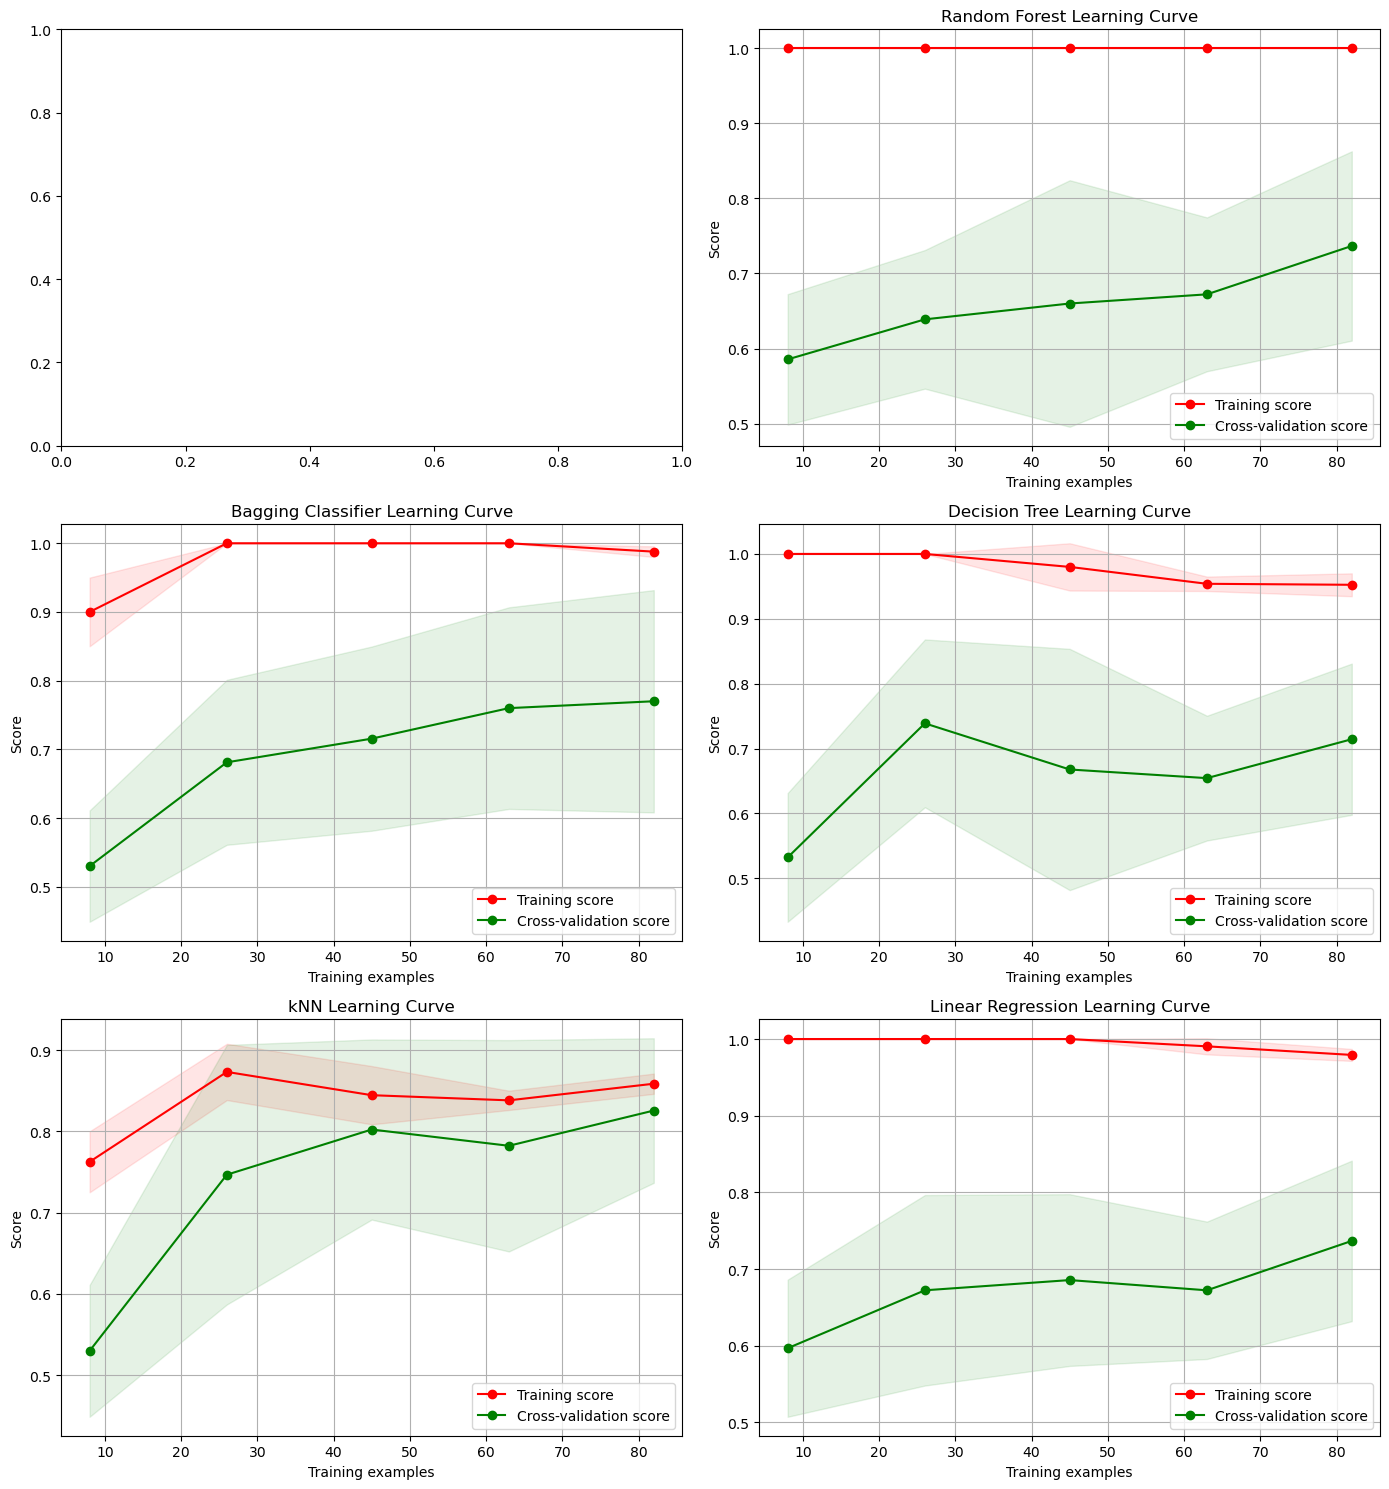


Best Overall Model: kNN

Final Model: kNN
Accuracy on the Test Set: 0.4348
F1 Score on the Test Set: 0.3810


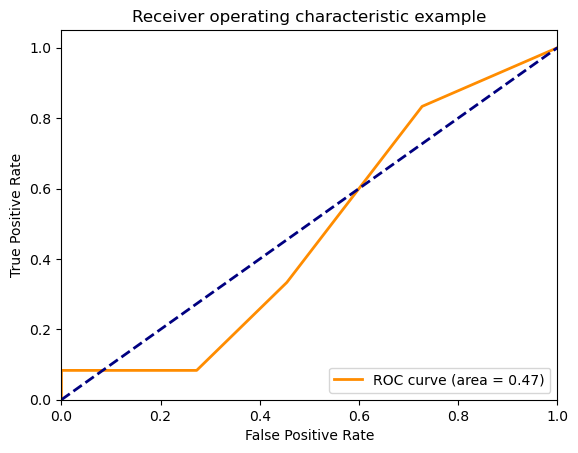

==============================END ONE FOLD==============================
==============================START ONE FOLD==============================
Series([], dtype: int64)
------------------------------Start feature selection------------------------------
Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
[VarianceThreshold] Remaining features: 168
[ANOVA] Selected top-75 features.


C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(custom_missing, np.nan, inplace=True)
C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(custom_missing, np.nan, inplace=True)


[Mutual Information] Selected top-75 features.
[Feature Union] Combined feature set size: 108
Testing n_features_to_select = 90


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 90 features: 1.0000

 Greedy Forward Selection complete.
Optimal number of features: 90
Best training accuracy: 1.0000
Testing n_features_to_select = 14
Accuracy for 14 features: 0.7717

 Greedy Forward Selection complete.
Optimal number of features: 14
Best training accuracy: 0.7717
Best k found by grid search: 4
Cross-validated accuracy: 0.6275
Testing n_features_to_select = 7
Accuracy for 7 features: 0.8261

 Greedy Forward Selection complete.
Optimal number of features: 7
Best training accuracy: 0.8261


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Best alpha: 91237.84911646122
Max alpha: 303940.171224037
Selected Features: Index([], dtype='object')
N features found: 0
Skipping Lasso for this fold: No features were selected by Lasso.
Selected 1 components to retain 95.0% variance.
Classifier: LogisticRegression
  Accuracy: 0.5326
  AUC: 0.4674
  F1-Score: 0.6667
  Precision: 0.5181
  Recall: 0.9348
--------------------------------------------------
Classifier: KNeighborsClassifier
  Accuracy: 0.6196
  AUC: 0.5676
  F1-Score: 0.6392
  Precision: 0.6078
  Recall: 0.6739
--------------------------------------------------
------------------------------Start training classifiers------------------------------

=== Model Comparison ===

Best Random Forest: RandomForestClassifier(max_depth=9, min_samples_split=14, n_estimators=79,
                       random_state=42)
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_split': 14, 'n_estimators': 79}
Best Random Forest Accuracy: 0.6756

Best Bagging: Bagging

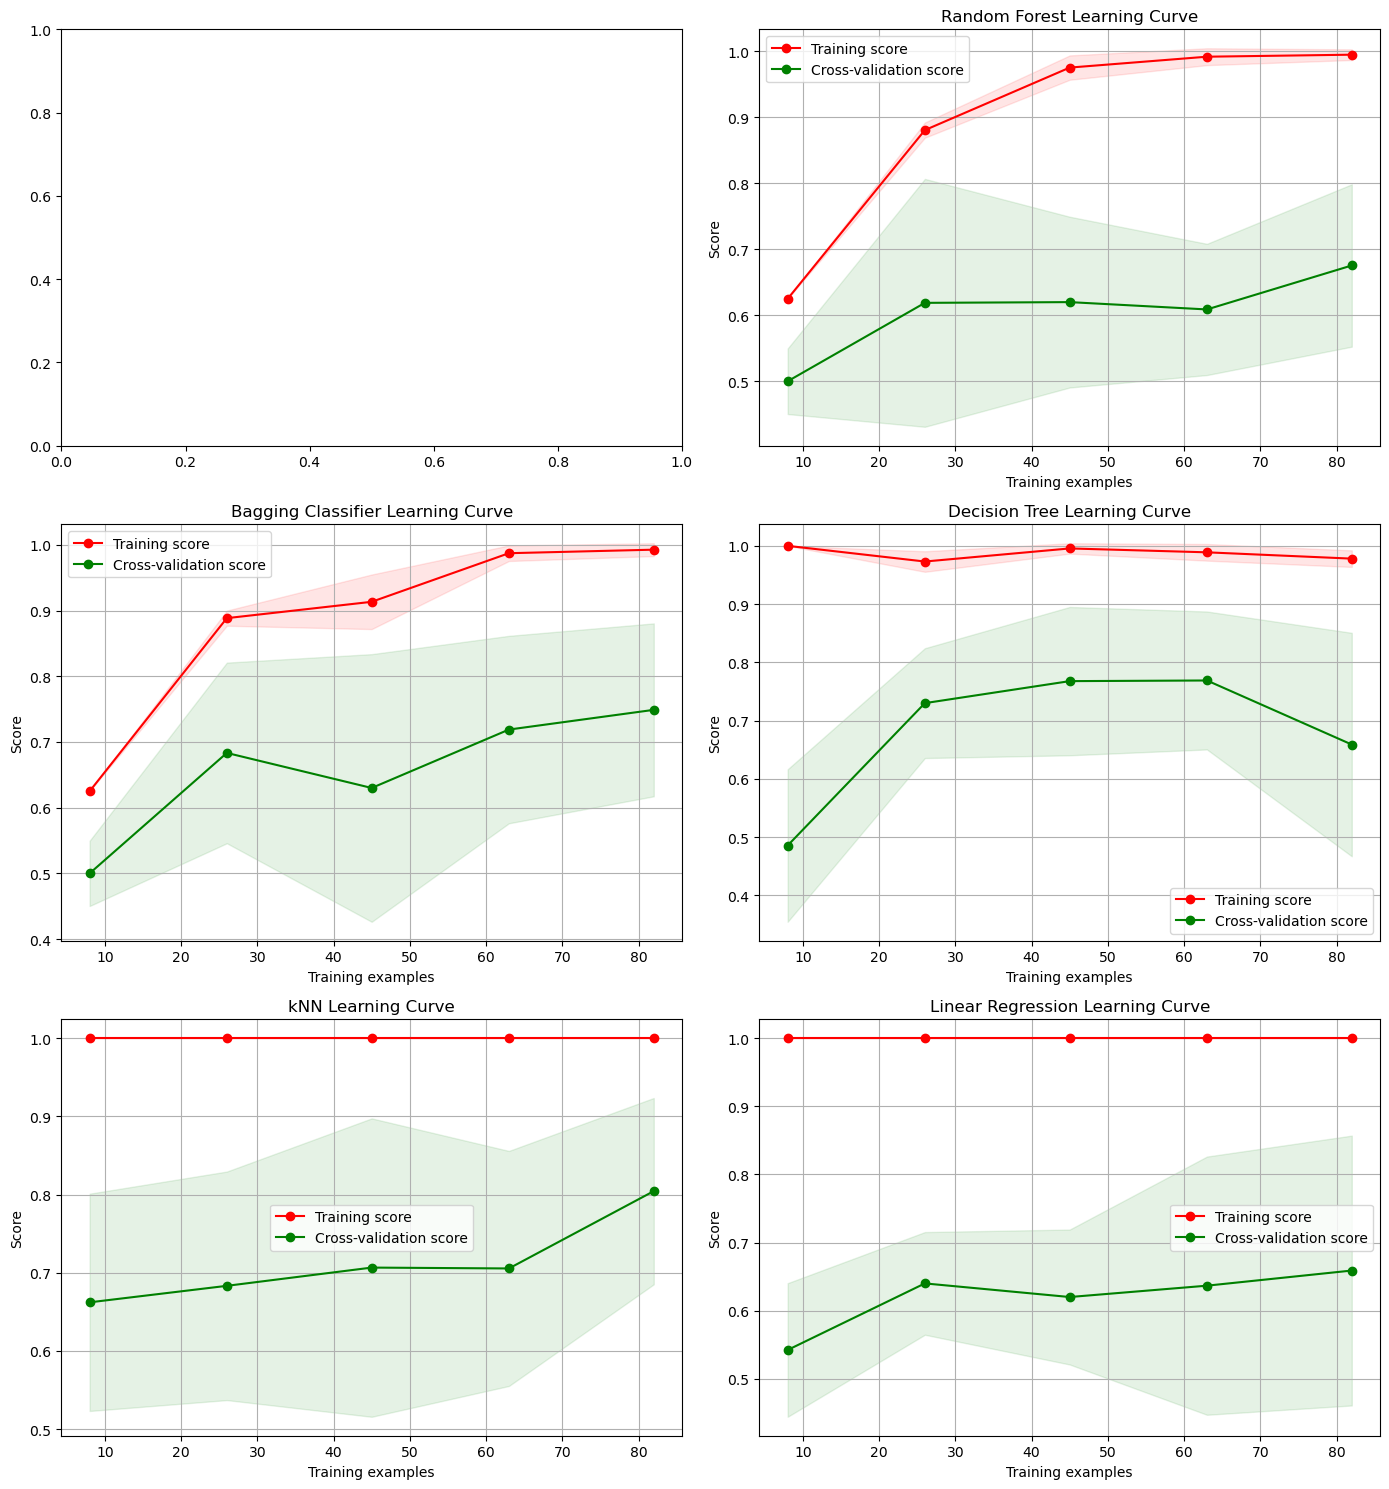


Best Overall Model: kNN

Final Model: kNN
Accuracy on the Test Set: 0.6087
F1 Score on the Test Set: 0.6400


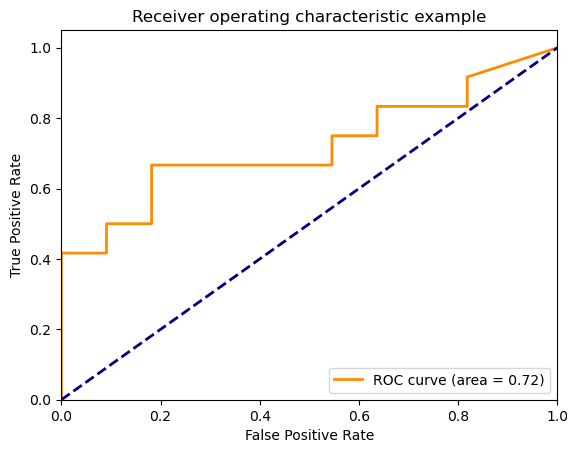

==============================END ONE FOLD==============================
==============================START ONE FOLD==============================
Series([], dtype: int64)


C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(custom_missing, np.nan, inplace=True)
C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(custom_missing, np.nan, inplace=True)


------------------------------Start feature selection------------------------------
Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
[VarianceThreshold] Remaining features: 166
[ANOVA] Selected top-75 features.
[Mutual Information] Selected top-75 features.
[Feature Union] Combined feature set size: 116
Testing n_features_to_select = 90


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 90 features: 0.9457

 Greedy Forward Selection complete.
Optimal number of features: 90
Best training accuracy: 0.9457
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8261

 Greedy Forward Selection complete.
Optimal number of features: 14
Best training accuracy: 0.8261
Best k found by grid search: 11
Cross-validated accuracy: 0.5982
Testing n_features_to_select = 7
Accuracy for 7 features: 0.7717

 Greedy Forward Selection complete.
Optimal number of features: 7
Best training accuracy: 0.7717


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Best alpha: 1064693.9996506616
Max alpha: 1064693.9996506614
Selected Features: Index([], dtype='object')
N features found: 0
Skipping Lasso for this fold: No features were selected by Lasso.
Selected 1 components to retain 95.0% variance.
Classifier: LogisticRegression
  Accuracy: 0.5109
  AUC: 0.4787
  F1-Score: 0.6154
  Precision: 0.5070
  Recall: 0.7826
--------------------------------------------------
Classifier: KNeighborsClassifier
  Accuracy: 0.5543
  AUC: 0.6368
  F1-Score: 0.5591
  Precision: 0.5532
  Recall: 0.5652
--------------------------------------------------
------------------------------Start training classifiers------------------------------

=== Model Comparison ===

Best Random Forest: RandomForestClassifier(bootstrap=False, max_depth=18, min_samples_split=17,
                       n_estimators=86, random_state=42)
Best Random Forest Parameters: {'bootstrap': False, 'max_depth': 18, 'min_samples_split': 17, 'n_estimators': 86}
Best Random Forest Accuracy: 0.7056

c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 446, in score
    return super().score(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\base.py", line 572, in score
    return accuracy_score(y, self.pre

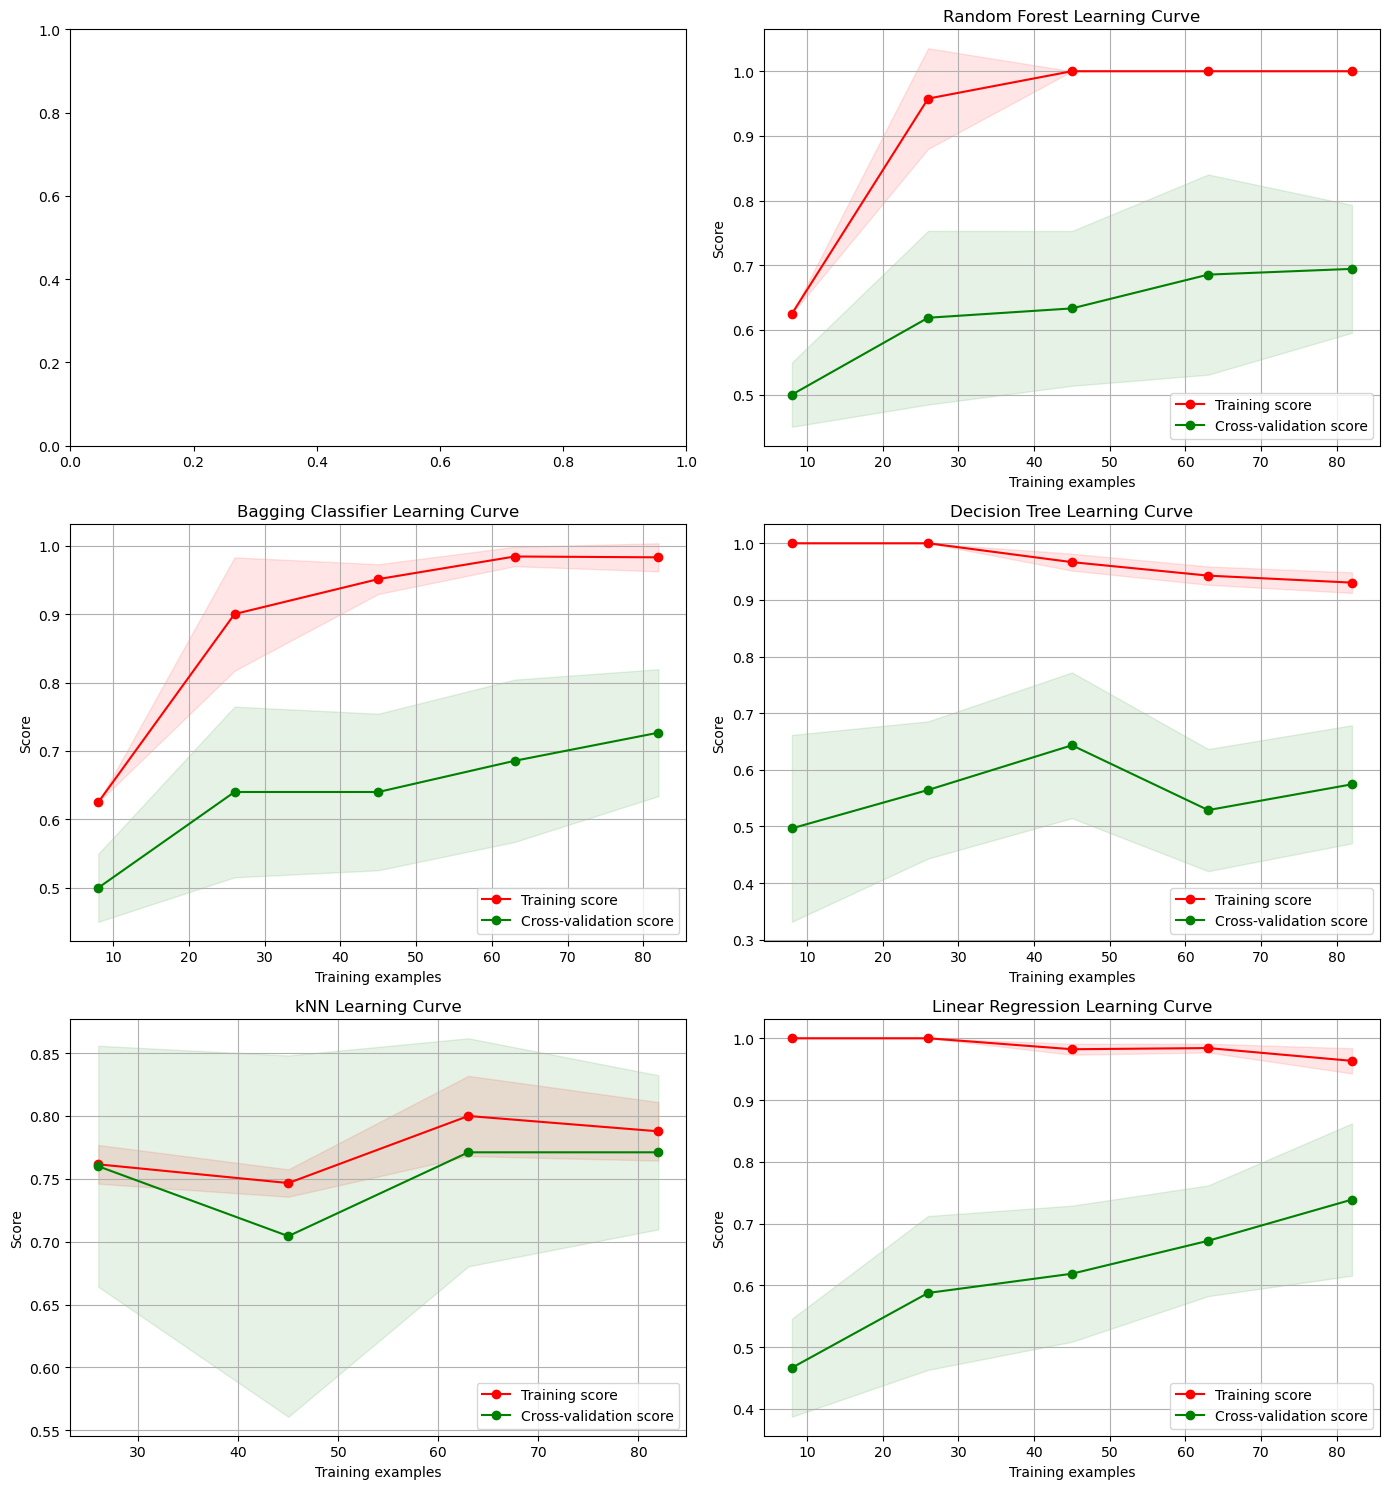


Best Overall Model: kNN

Final Model: kNN
Accuracy on the Test Set: 0.5217
F1 Score on the Test Set: 0.5600


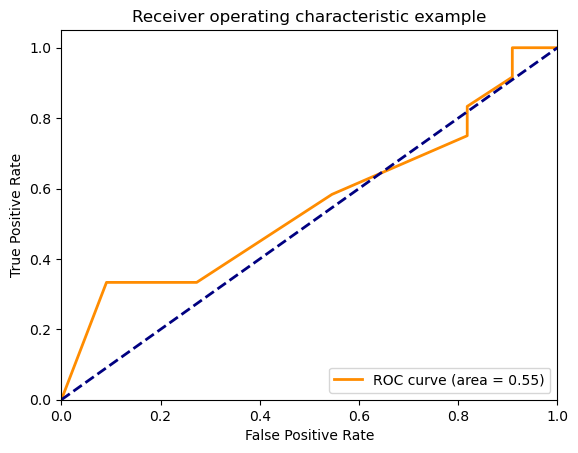

==============================END ONE FOLD==============================
==============================START ONE FOLD==============================
Series([], dtype: int64)
------------------------------Start feature selection------------------------------
Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
[VarianceThreshold] Remaining features: 154
[ANOVA] Selected top-75 features.


C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(custom_missing, np.nan, inplace=True)
C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(custom_missing, np.nan, inplace=True)


[Mutual Information] Selected top-75 features.
[Feature Union] Combined feature set size: 107
Testing n_features_to_select = 90


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 90 features: 0.9891

 Greedy Forward Selection complete.
Optimal number of features: 90
Best training accuracy: 0.9891
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8043

 Greedy Forward Selection complete.
Optimal number of features: 14
Best training accuracy: 0.8043
Best k found by grid search: 14
Cross-validated accuracy: 0.6298
Testing n_features_to_select = 7
Accuracy for 7 features: 0.8043

 Greedy Forward Selection complete.
Optimal number of features: 7
Best training accuracy: 0.8043


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Best alpha: 953079.0481137494
Max alpha: 953079.0481137502
Selected Features: Index([], dtype='object')
N features found: 0
Skipping Lasso for this fold: No features were selected by Lasso.
Selected 1 components to retain 95.0% variance.
Classifier: LogisticRegression
  Accuracy: 0.5543
  AUC: 0.4823
  F1-Score: 0.6822
  Precision: 0.5366
  Recall: 0.9362
--------------------------------------------------
Classifier: KNeighborsClassifier
  Accuracy: 0.5543
  AUC: 0.5790
  F1-Score: 0.5773
  Precision: 0.5600
  Recall: 0.5957
--------------------------------------------------
------------------------------Start training classifiers------------------------------

=== Model Comparison ===

Best Random Forest: RandomForestClassifier(max_depth=9, min_samples_split=16, n_estimators=12,
                       random_state=42)
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_split': 16, 'n_estimators': 12}
Best Random Forest Accuracy: 0.6622

Best Bagging: Baggin

c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 472, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\neighbors\_classification.py", line 446, in score
    return super().score(X, y, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\base.py", line 572, in score
    return accuracy_score(y, self.pre

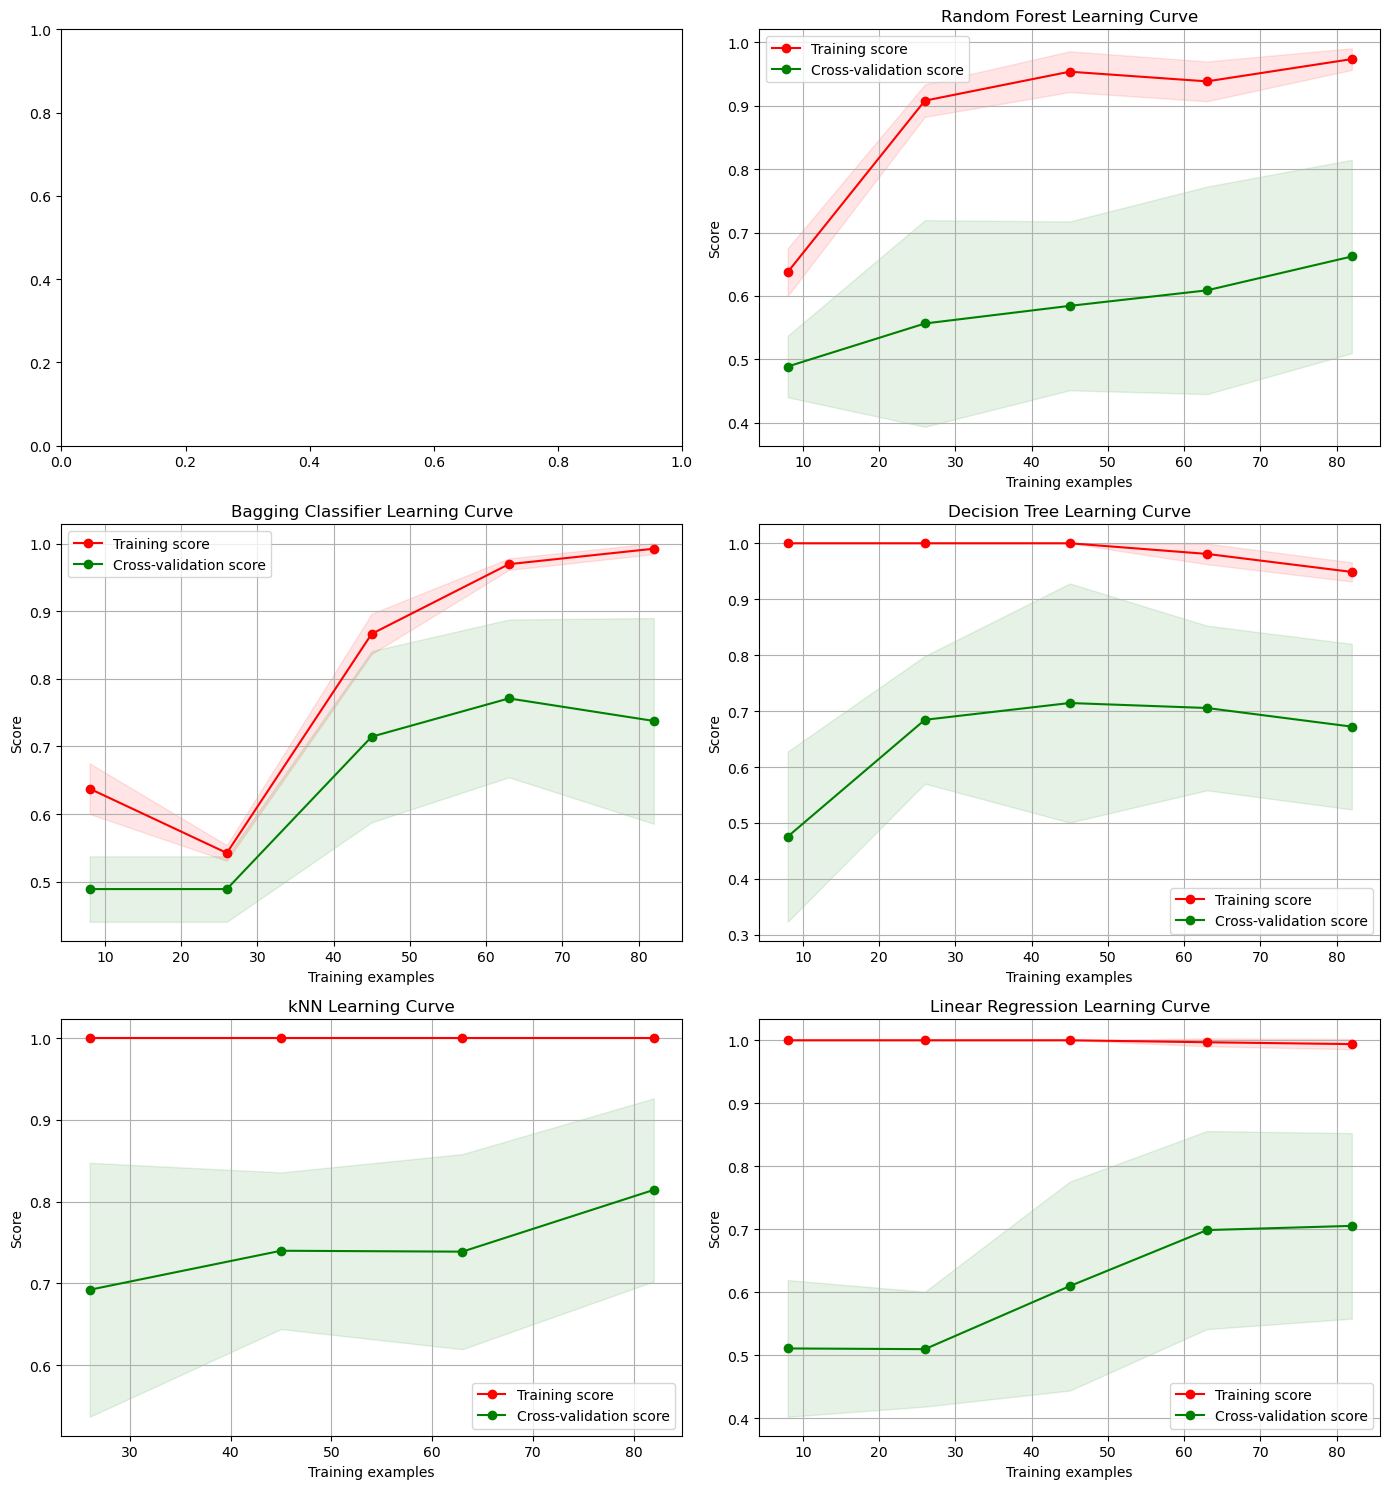


Best Overall Model: kNN

Final Model: kNN
Accuracy on the Test Set: 0.7826
F1 Score on the Test Set: 0.8000


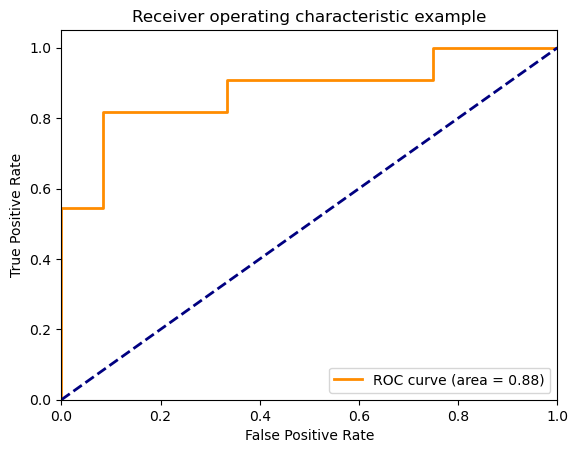

==============================END ONE FOLD==============================
==============================START ONE FOLD==============================
Series([], dtype: int64)


C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.replace(custom_missing, np.nan, inplace=True)
C:\Users\loisb\AppData\Local\Temp\ipykernel_7588\1119776968.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.replace(custom_missing, np.nan, inplace=True)


------------------------------Start feature selection------------------------------
Label Mapping: {0: 'lipoma', 1: 'liposarcoma'}
[VarianceThreshold] Remaining features: 167
[ANOVA] Selected top-75 features.
[Mutual Information] Selected top-75 features.
[Feature Union] Combined feature set size: 105
Testing n_features_to_select = 90


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy for 90 features: 0.9783

 Greedy Forward Selection complete.
Optimal number of features: 90
Best training accuracy: 0.9783
Testing n_features_to_select = 14
Accuracy for 14 features: 0.8804

 Greedy Forward Selection complete.
Optimal number of features: 14
Best training accuracy: 0.8804
Best k found by grid search: 10
Cross-validated accuracy: 0.5865
Testing n_features_to_select = 7
Accuracy for 7 features: 0.7717

 Greedy Forward Selection complete.
Optimal number of features: 7
Best training accuracy: 0.7717


c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\loisb\miniconda3\Lib\site-packages\sklearn\feature_selection\_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


Best alpha: 987321.9235839705
Max alpha: 987321.9235839702
Selected Features: Index([], dtype='object')
N features found: 0
Skipping Lasso for this fold: No features were selected by Lasso.
Selected 1 components to retain 95.0% variance.
Classifier: LogisticRegression
  Accuracy: 0.5543
  AUC: 0.4709
  F1-Score: 0.6870
  Precision: 0.5357
  Recall: 0.9574
--------------------------------------------------
Classifier: KNeighborsClassifier
  Accuracy: 0.6739
  AUC: 0.7069
  F1-Score: 0.6667
  Precision: 0.6977
  Recall: 0.6383
--------------------------------------------------
------------------------------Start training classifiers------------------------------

=== Model Comparison ===

Best Random Forest: RandomForestClassifier(max_depth=19, min_samples_split=12, n_estimators=167,
                       random_state=42)
Best Random Forest Parameters: {'bootstrap': True, 'max_depth': 19, 'min_samples_split': 12, 'n_estimators': 167}
Best Random Forest Accuracy: 0.7378

Best Bagging: Ba

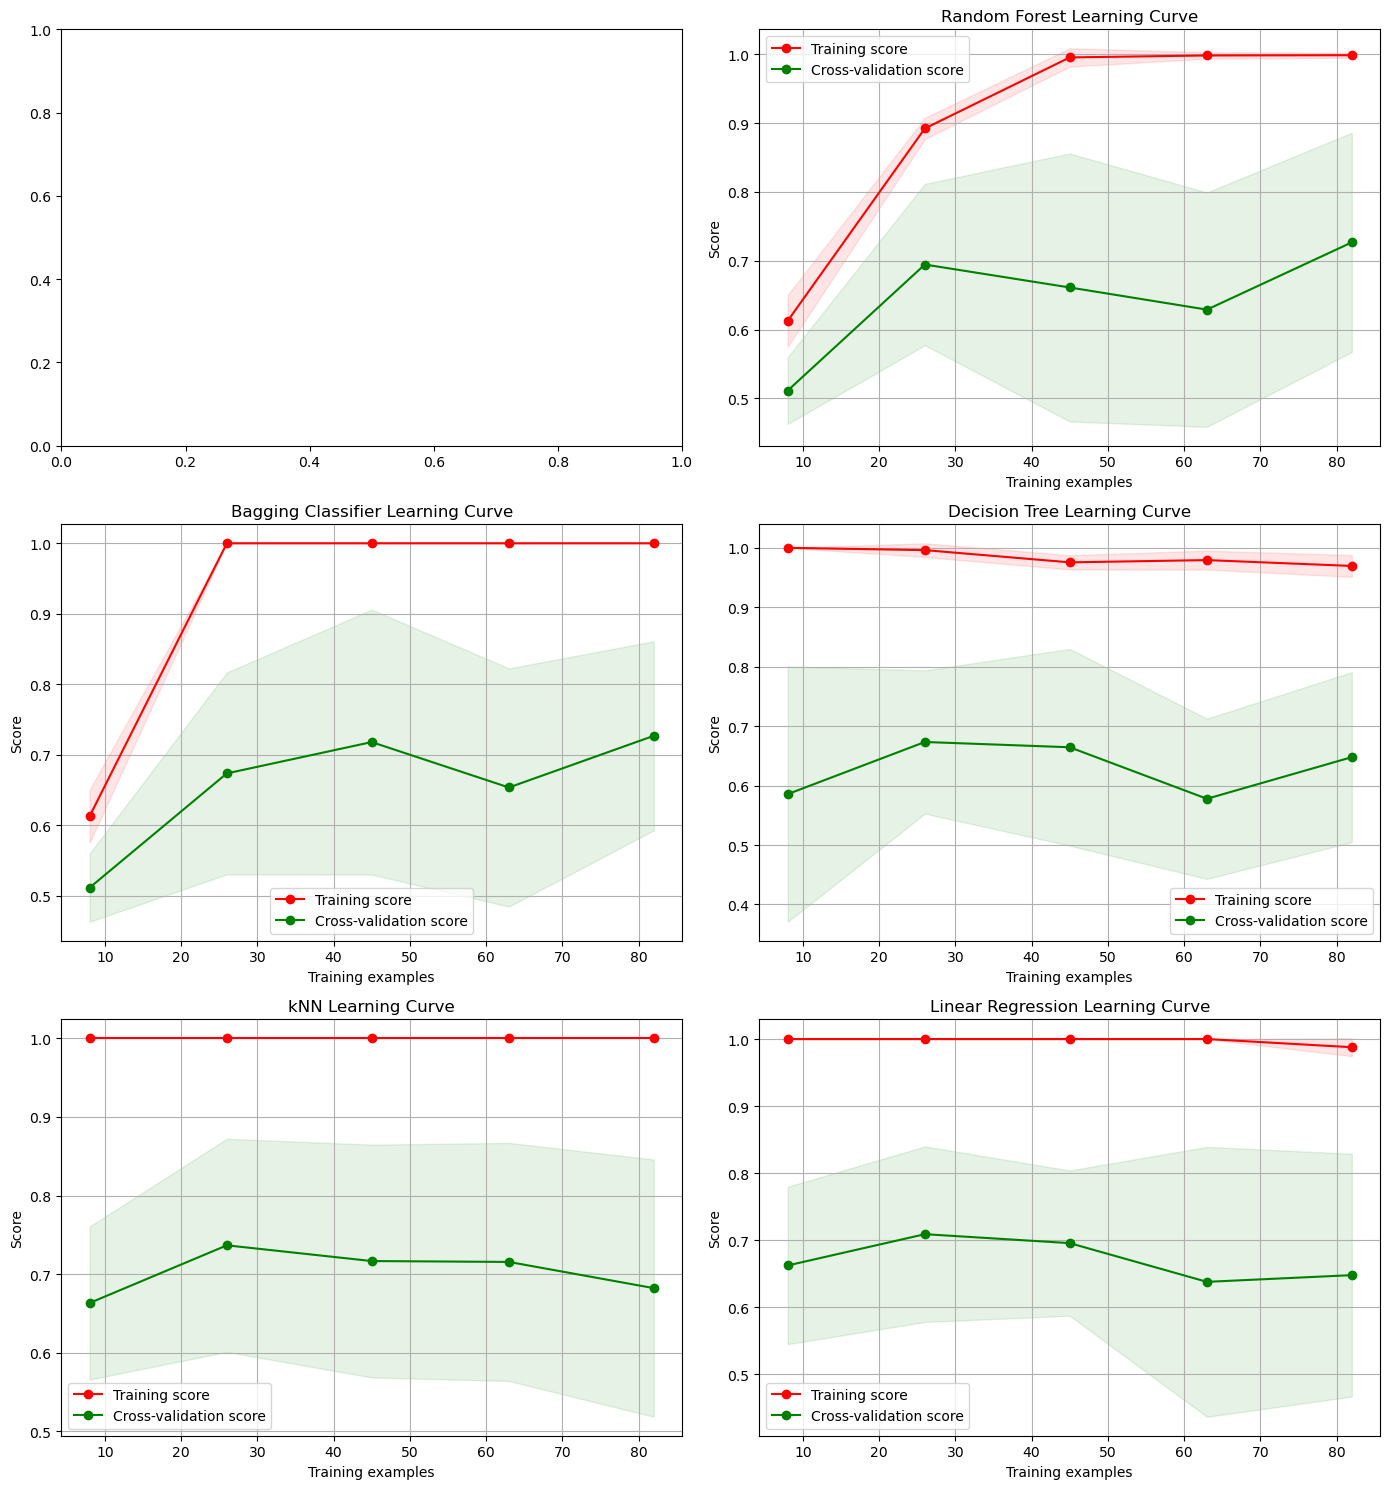


Best Overall Model: kNN

Final Model: kNN
Accuracy on the Test Set: 0.4348
F1 Score on the Test Set: 0.4800


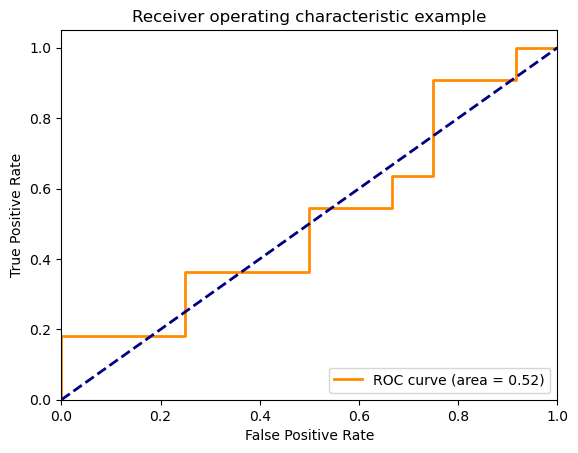

==============================END ONE FOLD==============================


In [61]:
cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_fpr = []
all_tpr = []
all_auc = []

# Loop over the folds
for validation_index, test_index in cv_5fold.split(X, y):
    # Split the data properly
    print('=' * 30 + 'START ONE FOLD' + '=' * 30)
    X_train = X.iloc[validation_index]
    y_train = y.iloc[validation_index]

    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]

    # Missing data
    total_missing = find_missing_data(X_train)
    X_train, X_test = process_missing_data(X_train, X_test, total_missing)

    # Scaling
    X_scaled_robust_train, X_scaled_robust_test = scaling(X_train, X_test)

    print('-' * 30 + 'Start feature selection' + '-' * 30)

    # Feature selection
    y_train_numeric, y_test_numeric = y_numeric(y_train, y_test)
    X_filtered_train_variance_new, X_filtered_test_variance_new, variance_filtered_features_new = apply_variance_threshold(X_scaled_robust_train, X_scaled_robust_test)
    X_filtered_train_anova_new, X_filtered_test_anova_new, anova_selected_features_new = select_features_anova(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
    X_filtered_train_mi_new, X_filtered_test_mi_new, mi_selected_features_new = select_features_mi(X_filtered_train_variance_new, y_train_numeric, X_filtered_test_variance_new)
    X_filtered_train_union_new, X_filtered_test_union_new, union_features_new = combine_feature_sets_union(X_filtered_train_variance_new, X_filtered_test_variance_new, anova_selected_features_new, mi_selected_features_new)
    
    X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, sfs_selected_features_logistic, number_of_sfs_selected_features_logistic, train_acc_logistic = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=LogisticRegression(max_iter=1000, random_state=42),
    feature_range=[90],
    scoring='accuracy'
    )

    X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, sfs_selected_features_logistic_max10, number_of_sfs_selected_features_logistic_max10, train_acc_logistic_max10 = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=LogisticRegression(max_iter=1000, random_state=42),
    feature_range=[14],
    scoring='accuracy'
    )

    knn_best = optimal_k(X_filtered_train_union_new, y_train_numeric)

    X_train_selected_sfs_knn, X_test_selected_sfs_knn, sfs_selected_features_knn, number_of_sfs_selected_features_knn, train_acc_knn = greedy_forward_selection(
    X_filtered_train_union_new, y_train_numeric, X_filtered_test_union_new,
    model=knn_best,
    feature_range=[7],
    scoring='accuracy'
    )
    
    # Try only the Lasso and its dependent parts
    try:
        alpha_info, X_train_sel_lasso, X_test_sel_lasso, selected_feature_names, n_features = lasso_fs(
            X_scaled_robust_train, X_scaled_robust_test, y_train_numeric
        )

        print(f"Best alpha: {alpha_info[0]}")
        print(f"Max alpha: {alpha_info[1]}")
        print("Selected Features:", selected_feature_names)
        print(f"N features found: {n_features}")

        if n_features == 0:
            raise ValueError("No features were selected by Lasso.")

        test_lasso(X_train_sel_lasso, X_test_sel_lasso, y_train_numeric)

    except ValueError as e:
        print(f"Skipping Lasso for this fold: {e}")


    pca, X_train_pca, X_test_pca, n_components_selected = PCA_fs(X_scaled_robust_train, X_scaled_robust_test, target_variance=0.95)
    test_pca(X_train_pca, X_test_pca, y_train_numeric)

    print('-' * 30 + 'Start training classifiers' + '-' * 30)

    # Classifiers
    best_estimators, y_train_encoded, best_scores = forest_tree_classifiers(y_train, X_train)
    #best_svm, best_score_svm = svm_classifier(X_train_selected_sfs_logistic_max10, y_train_encoded)
    best_knn, best_score_knn = knn_classifier(X_train_selected_sfs_knn, y_train_encoded)
    log_reg_score, log_reg_model = lr_classifier(X_train_selected_sfs_logistic, y_train_encoded)

    # Learning curves
    learning_curves(best_estimators, X_train, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_train_selected_sfs_knn, log_reg_model)

    # Evaluation
    fpr, tpr, auc_value = evaluation_classifiers(best_scores, best_score_knn, X_scaled_robust_train, X_scaled_robust_test, y_train_encoded, best_knn, X_train_selected_sfs_logistic, X_test_selected_sfs_logistic, X_train_selected_sfs_logistic_max10, X_test_selected_sfs_logistic_max10, X_train_selected_sfs_knn, X_test_selected_sfs_knn, y_test, y_train, log_reg_score, best_estimators)

    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_value)

    print('=' * 30 + 'END ONE FOLD' + '=' * 30)


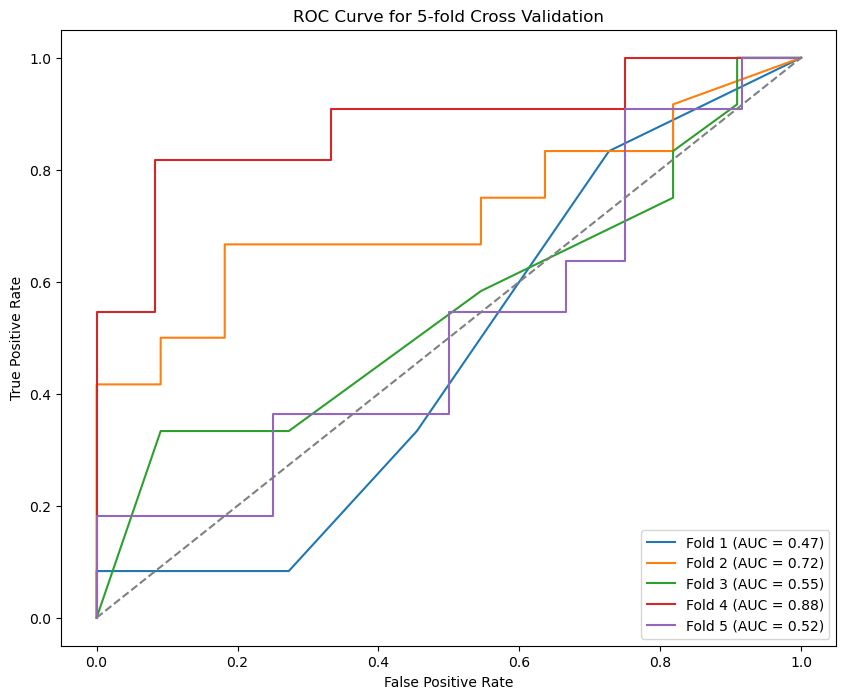

In [62]:
# Plot combined ROC
plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'Fold {i+1} (AUC = {all_auc[i]:.2f})')
    
# Plot a diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for 5-fold Cross Validation')
plt.legend(loc='lower right')
plt.show()

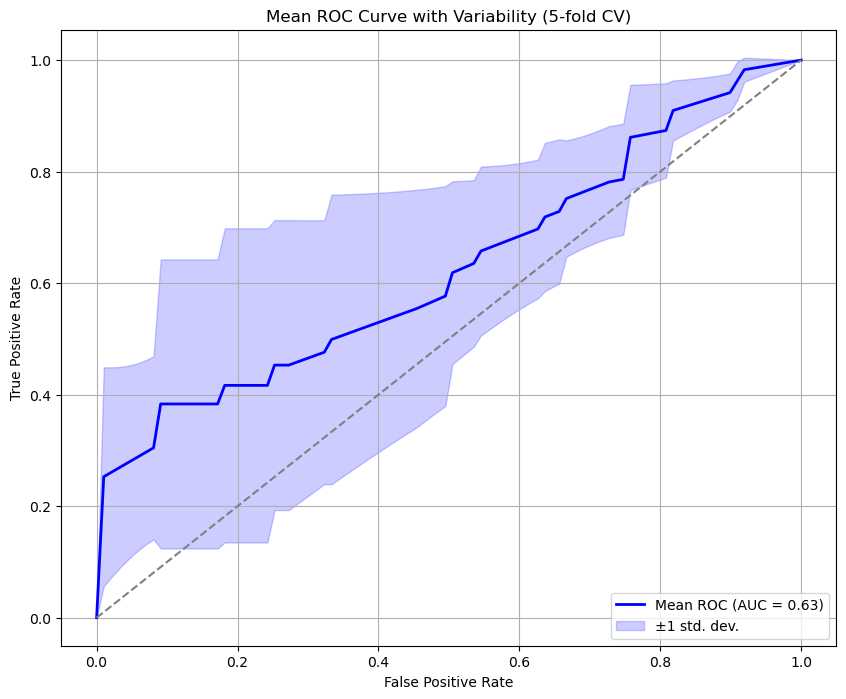

In [63]:
# Define common FPR range
mean_fpr = np.linspace(0, 1, 100)
interp_tprs = []

# Interpolate each fold's TPRs at mean_fpr points
for i in range(len(all_fpr)):
    interp_tpr = np.interp(mean_fpr, all_fpr[i], all_tpr[i])
    interp_tpr[0] = 0.0  # Ensure start at 0
    interp_tprs.append(interp_tpr)

interp_tprs = np.array(interp_tprs)
mean_tpr = np.mean(interp_tprs, axis=0)
std_tpr = np.std(interp_tprs, axis=0)
mean_tpr[-1] = 1.0  # Ensure end at 1

mean_auc = auc(mean_fpr, mean_tpr)

# Plot mean ROC and shaded std deviation
plt.figure(figsize=(10, 8))
plt.plot(mean_fpr, mean_tpr, color='blue', label=f'Mean ROC (AUC = {mean_auc:.2f})', linewidth=2)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr,
                 color='blue', alpha=0.2, label='±1 std. dev.')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC Curve with Variability (5-fold CV)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
